#  <span style='color:blue'> Handwritten Digit Classification Using the MNIST Dataset – A Convolutional Neural Network Approach </span>
**Author :** [Bitewulign Kassa Mekonnen](https://scholar.google.com/citations?user=SHPCjakAAAAJ&hl=en)<br>
**Instructor :** Hossein Pourmodheji <br>
**Lab Assistant :** Sebastian<br>
**Date created :**  2024/10/10<br>
**Last modified :** 2024/10/21  <br>

**Objective:** To apply various preprocessing and machine learning techniques to 
classify handwritten digits from the MNIST (alternative link) dataset without using 
deep learning methods. <br>

**Project Description :** The MNIST dataset is a collection of 70,000 grayscale images of handwritten digits (0-9), 60,000 train and 10,000 test datasets. Each image is 28x28 pixels. The goal of this project is to build a machine learning model that can accurately classify these images into the correct digit categories. <br>


<span style='color:red; font-size: 12px;'> <b>Note:</b>  This project is developed to fulfill the requirements of the Bridge to Cloud Computing and Big Data course. </span>

In [1]:
import warnings
import sys
import os, shutil
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
#U-net model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Conv2D,
                                     MaxPooling2D,
                                     Dense,
                                     Flatten,
                                     Input,
                                     BatchNormalization,
                                     Dropout)
from tensorflow.keras.callbacks import (EarlyStopping, 
                             ModelCheckpoint)
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_auc_score,
                             confusion_matrix,
                             roc_curve, auc,
                             classification_report)
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
from sklearn.preprocessing import label_binarize
from tensorflow.keras.regularizers import l2
from sklearn.metrics import precision_recall_curve, average_precision_score

<center>
<b><span style="font-size: 36px;">Part 1: Data Preprocessing</span></b>
</center>


1. Data Loading:

    ➢ Use fetch_openml from scikit-learn to load the MNIST dataset.
    
    ➢ Explore the dataset to understand its structure (number of samples, feature dimentions, etc.)
    
2. Data Normalization:

    ➢ Normalize the pixel values to a range of 0 to 1 to ensure uniformity in the input data scale. 
    
3. Data Visualization: 

    ➢ Visualize a subset of images using matplotlib to get a sense of what the handwritten digits look like. 
    
4. Dimentionality Reduction (optional):

    ➢ Apply PCA to reduce the dimentionality of the dataset while preserving most of the variance.

In [2]:
# 1. Data Loading
mnist = fetch_openml('mnist_784', as_frame=False)
X_data, Y_data = mnist["data"], mnist['target'].astype(np.uint8)
X_data= X_data.reshape(X_data.shape[0], 28, 28)

print(f'X shape: {X_data.shape}, Y shape : {Y_data.shape}')

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=10000, random_state=42)
print(f'X-train shape : {X_train.shape}, X-test shape : {X_test.shape}, Y-train shape : {y_train.shape},  Y-test shape : {y_test.shape}')

X shape: (70000, 28, 28), Y shape : (70000,)
X-train shape : (60000, 28, 28), X-test shape : (10000, 28, 28), Y-train shape : (60000,),  Y-test shape : (10000,)


## Reshaping the data

In order to use convolution layers we need to reshape our data and add a color channel to it. As you've noticed currently every digit has a shape of `(28, 28)` which means that it is a 28x28 matrix of color values form `0` to `255`. We need to reshape it to `(28, 28, 1)` shape so that each pixel potentially may have multiple channels (like Red, Green and Blue).

In [3]:
# Reshape the data to add the channel dimension (for CNN input)

x_train = X_train.astype('float32').reshape(-1, 28, 28, 1)
x_test = X_test.astype('float32').reshape(-1, 28, 28, 1)

# Set data types for categorical labels
Y_train = y_train.copy()
y_train = utils.to_categorical(y_train, 10)
#y_test = utils.to_categorical(y_test)

print('X train shape: {}, Y train shape : {}'.format(x_train.shape, y_train.shape))
print('X test shape: {}, Y test shape : {}'.format(x_test.shape, y_test.shape))
print('Ready...')

X train shape: (60000, 28, 28, 1), Y train shape : (60000, 10)
X test shape: (10000, 28, 28, 1), Y test shape : (10000,)
Ready...


### Data Normalization: 
➢ Normalize the pixel values to a range of 0 to 1 to ensure uniformity in the 
input data scale. 

In [4]:
x_train = x_train / 255
x_test = x_test / 255

####  3. Data Visualization: 
➢ Visualize a subset of images using matplotlib to get a sense of what the 
handwritten digits look like. 
Lets print some more training examples to get the feeling ogf how the digits were written

In [5]:

# 3. Data Visualization
def plot_sample_images(X, y, n_samples=10, figs = (10,10)):
    plt.figure(figsize=figs)
    # Calculate the grid size
    rows_cols = int(np.ceil(np.sqrt(n_samples)))
    for i in range(n_samples):
        plt.subplot(rows_cols, rows_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(f"L: {y[i]}", color = 'blue')
        plt.axis('off')
    plt.show()

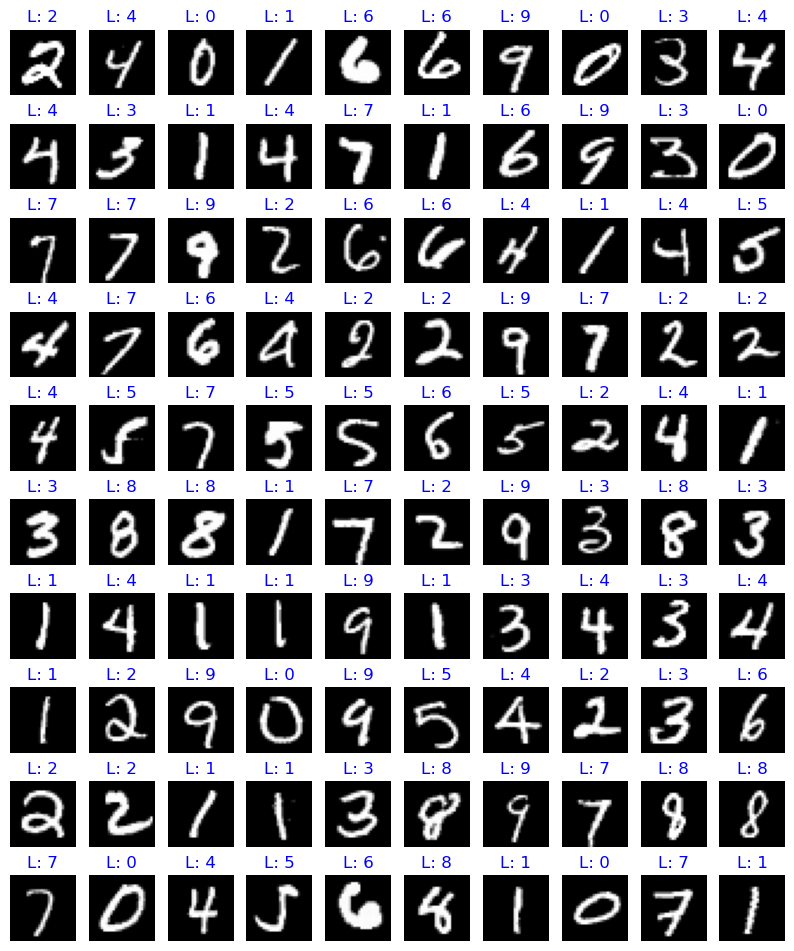

In [6]:
plot_sample_images(x_train, Y_train, n_samples = 100, figs = (10,12))

<center>
<b><span style="font-size: 36px;">Part 2: Machine Learning</span></b>
</center>

1.  Model Selection:<br>
     ➢ Choose CNN (Convolutional Neural Network) for the model training.
     
     
2. Model Training:<br>
    ➢ Split the dataset into training and testing sets. (60,000 train and 10,000 test)
    
    ➢ Train each model on the training set.
    
3. Model Evaluation:

    ➢ Evaluate each model’s performance on the testing set using metrics such as accuracy, precision, recall, and F1-score.
    
    ➢ Use a confusion matrix to visualize the performance of each model.

In [7]:
inputs = Input((28, 28, 1))
x = Conv2D(filters=8, kernel_size=5,activation='relu', kernel_regularizer=l2(0.001))(inputs)

x= MaxPooling2D(pool_size=(2, 2),)(x)

x = Conv2D(filters=16, kernel_size=5, padding = 'same', activation= 'relu', kernel_regularizer=l2(0.001))(x)

x = MaxPooling2D(pool_size=(2, 2),)(x)

x = Conv2D(filters=32, kernel_size=5, activation= 'relu', kernel_regularizer=l2(0.001))(x)

f = Flatten()(x)

d = Dense(units=128,activation='relu', kernel_regularizer=l2(0.001))(f)

d = Dropout(0.2)(d)

outputs = Dense(units=10, activation= 'softmax',)(d)
model = Model(inputs=[inputs], outputs=[outputs])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          12832 

2024-10-15 21:49:28.704401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 21:49:28.704538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 21:49:28.706973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 21:49:28.707071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-15 21:49:28.707148: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [8]:
# plot_model(model, show_shapes=True, show_layer_names=True,)

## Compile the model and Train the model

In [9]:
adam_optimizer = Adam(learning_rate=0.0001)

model.compile(optimizer=adam_optimizer,loss= 'categorical_crossentropy',metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpointer = ModelCheckpoint('models/cnn-project-training-digits-classifier.h5', verbose=1, save_best_only=True)

training_history = model.fit(x_train,
                             y_train,
                             epochs=100,
                             validation_split = 0.1,
                             callbacks=[early_stop, checkpointer])

Epoch 1/100
  67/1688 [>.............................] - ETA: 2s - loss: 2.4274 - accuracy: 0.1693 

2024-10-15 21:49:29.898138: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8700
2024-10-15 21:49:29.909616: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-15 21:49:29.911387: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-10-15 21:49:29.911393: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at /usr/local/cuda-11.2/bin/ptxas
2024-10-15 21:49:29.911421: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: /usr/local/cuda-11.2/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-10-15 21:49:29.966672: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This w

1688/1688 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.8006
Epoch 00001: val_loss improved from inf to 0.33913, saving model to models/cnn-project-training-digits-classifier.h5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.7846 - accuracy: 0.8006 - val_loss: 0.3391 - val_accuracy: 0.9347
Epoch 2/100
1663/1688 [============================>.] - ETA: 0s - loss: 0.3419 - accuracy: 0.9345
Epoch 00002: val_loss improved from 0.33913 to 0.26731, saving model to models/cnn-project-training-digits-classifier.h5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3410 - accuracy: 0.9347 - val_loss: 0.2673 - val_accuracy: 0.9550
Epoch 3/100
1659/1688 [============================>.] - ETA: 0s - loss: 0.2750 - accuracy: 0.9523
Epoch 00003: val_loss improved from 0.26731 to 0.23312, saving model to models/cnn-project-training-digits-classifier.h5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2749 - accuracy: 0.9523

In [10]:
del model

In [11]:
## Save to csv history
hist_dic = {'train_loss': training_history.history['loss'],
           'valid_loss': training_history.history['val_loss'],
           'train_acc': training_history.history['accuracy'],
           'valid_acc':training_history.history['val_accuracy']
           }
hist_df = pd.DataFrame(hist_dic)

In [12]:
hist_df

,train_loss,valid_loss,train_acc,valid_acc
0,0.784582,0.339132,0.800556,0.934667
1,0.341028,0.267315,0.934704,0.955000
2,0.274917,0.233121,0.952333,0.965333
3,0.239596,0.210975,0.962111,0.970167
4,0.218352,0.195974,0.967574,0.972500
...,...,...,...,...
89,0.050677,0.061123,0.995167,0.990667
90,0.050025,0.058537,0.995463,0.991333
91,0.050761,0.060733,0.994944,0.991500
92,0.050157,0.065276,0.995185,0.988667


In [13]:
hist_df.to_csv('results/cnn-history-cnn-training-digits-classifier.csv',  index = False)#header = header,

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


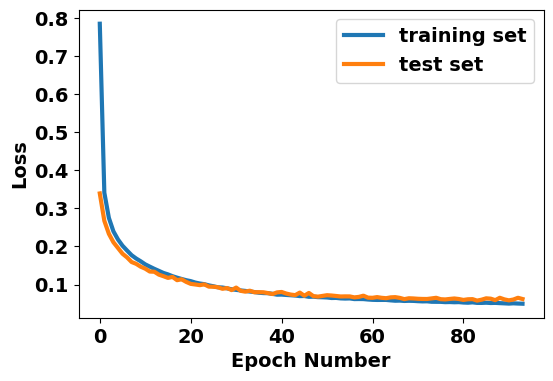

In [14]:
## Summarize history for loss
import matplotlib.font_manager as font_manager
plt.figure(figsize=(6,4))
plt.plot(training_history.history['loss'], label='training set', lw =3)
plt.plot(training_history.history['val_loss'], label='test set', lw = 3)
# plt.plot( np.argmin(valid_hist), np.min(valid_hist), marker="x", color="r", label="best model")
plt.xlabel("Epoch Number", fontweight = 'bold', fontsize = 14)
plt.ylabel("Loss",fontweight = 'bold', fontsize = 14)
plt.xticks(fontweight = 'bold', fontsize = 14)
plt.yticks(fontweight = 'bold', fontsize = 14)
font = font_manager.FontProperties(family='Times New Roman', weight='bold', style='normal', size=14)
plt.legend(prop = font)
plt.show()

In [15]:

## If custom used
loaded_model = load_model('models/cnn-project-training-digits-classifier.h5')
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 8)         208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          12832 

<center>
<b><span style="font-size: 36px;">Part 3: Reporting</span></b>
</center>

1.  Results Compilation:

     ➢ Compile the results from each model into a report.
     
     ➢ Include visualizations such as ROC curves and Precision-Recall curves.
     
2. Discussion:

     ➢ Discuss the performance of each model and the impact of preprocessing techniques.
     
     ➢ Provide insights on which model worked best and hypothesize why.

### Import Testing data

In [16]:
# Predict on  the test data
preds_test = loaded_model.predict(x_test, verbose=1)
y_pred = np.argmax(preds_test, axis=1)
# preds_test

313/313 [==============================] - 0s 593us/step


In [17]:
cnn_test_pred = pd.DataFrame({'y  test': y_test, 'y prediction': y_pred})
cnn_test_pred.to_csv('results/cnn_performance_results_v01.csv', index=False)

In [18]:
# Compute the classification report (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       1.00      1.00      1.00      1152
           2       0.98      0.99      0.99       967
           3       0.99      0.99      0.99      1034
           4       0.99      0.99      0.99       906
           5       0.99      0.99      0.99       937
           6       0.99      1.00      0.99       961
           7       0.99      0.99      0.99      1055
           8       0.98      0.98      0.98       969
           9       0.99      0.98      0.99      1036

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [19]:
def weighted_accuracy(y_true, y_pred):
    # Calculate precision, recall, f1 score, and accuracy
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"weighted Precision: {precision}")
    print(f"weighted Recall: {recall}")
    print(f"weighted F1 Score: {f1}")
    print(f"weighted Accuracy: {accuracy}")

    weighte_performance = {'Accuracy': round(accuracy,3), 
                           'precision': round(precision, 3),
                           'recall': round(recall, 3), 
                           'f1_score': round(f1, 3)}
    
    df = pd.DataFrame([weighte_performance])
    df.rename(index = {0:'weighted avg'}, inplace = True)
    return df

In [20]:
def Compute_macro_Accuracy(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    F1_score = f1_score(y_true, y_pred,average='macro')

    print(f"macro precision: {precision}")
    print(f"macro Recall: {recall}")
    print(f"macro F1 Score: {F1_score}")
    print(f"macro Accuracy: {acc}")

    performances = {'Accuracy': round(acc,3), 
                    'precision': round(precision, 3),
                    'recall': round(recall, 3),
                      'f1_score': round(F1_score, 3)}
    performances  = pd.DataFrame([performances])
    performances.rename(index = {0:'macro avg'}, inplace = True)
    return performances

In [21]:
#Compute weighted average
weighted_performance = weighted_accuracy(y_test, y_pred)

# Compute macro avg
macro_avg_accuracy = Compute_macro_Accuracy(y_test, y_pred)

accuracy_results = pd.concat([weighted_performance, macro_avg_accuracy])
accuracy_results

weighted Precision: 0.9897134513799208
weighted Recall: 0.9897
weighted F1 Score: 0.9896974890464367
weighted Accuracy: 0.9897
macro precision: 0.9896298507950023
macro Recall: 0.9896152432336056
macro F1 Score: 0.9896132496899478
macro Accuracy: 0.9897


,Accuracy,precision,recall,f1_score
weighted avg,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,0.99


In [22]:

def plot_confusion_matrix(cm, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title(title, fontsize = 16, fontweight = 'bold')
    plt.colorbar()
    tick_marks = np.arange(len(cm))
    plt.xticks(tick_marks, tick_marks, fontweight = 'bold')
    plt.yticks(tick_marks, tick_marks, fontweight = 'bold')
    
    # Label the counts inside the confusion matrix cells
    thresh = cm.max() / 2.  # threshold to set text color
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label', fontweight = 'bold')
    plt.xlabel('Predicted label', fontweight = 'bold')
    plt.tight_layout()
    plt.show()

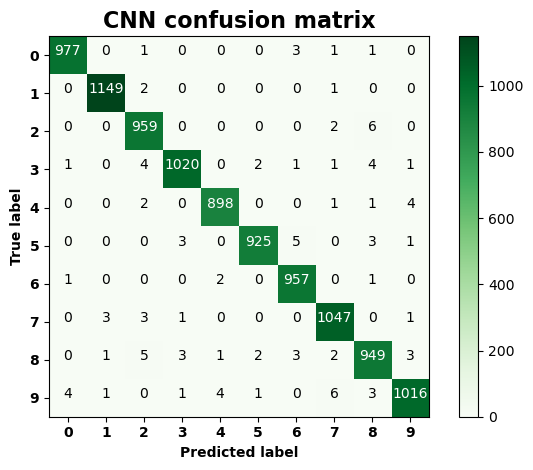

In [23]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, title = 'CNN confusion matrix')

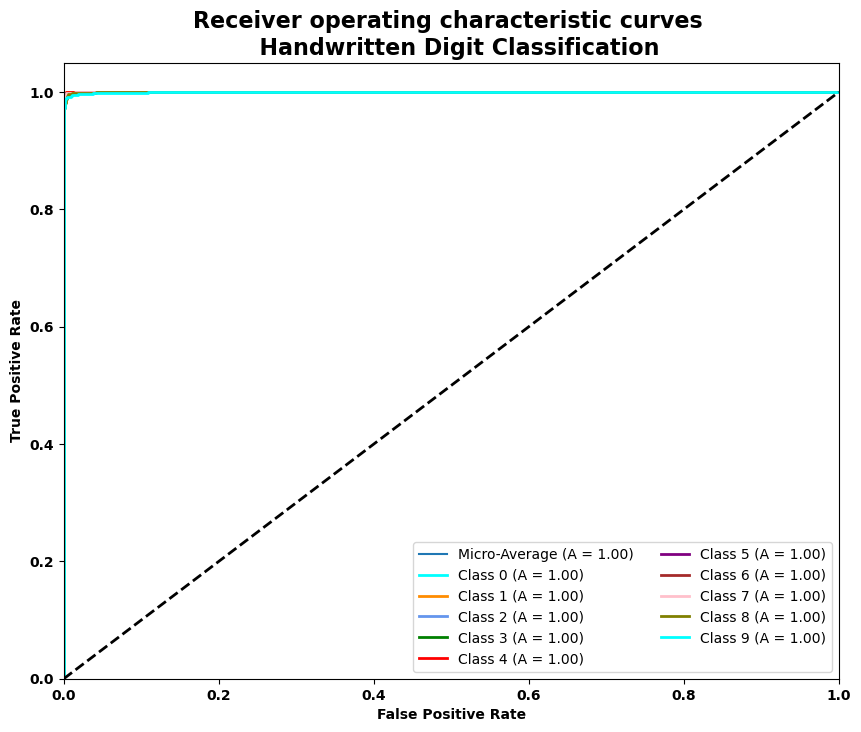

In [24]:
# Binarize the output labels (convert them to one-vs-rest format)
y_true = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_true.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], preds_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area (aggregate of all classes)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), preds_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for each class and the micro-average ROC curve
plt.figure(figsize = (10,8))
plt.plot(fpr["micro"], tpr["micro"], 
         label='Micro-Average (A = {0:0.2f})'.format(roc_auc["micro"]))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='Class {0} (A = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight = 'bold')
plt.ylabel('True Positive Rate', fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Receiver operating characteristic curves \n  Handwritten Digit Classification', fontweight = 'bold', fontsize = 16)
plt.legend(loc="lower right", ncol = 2)
plt.show()

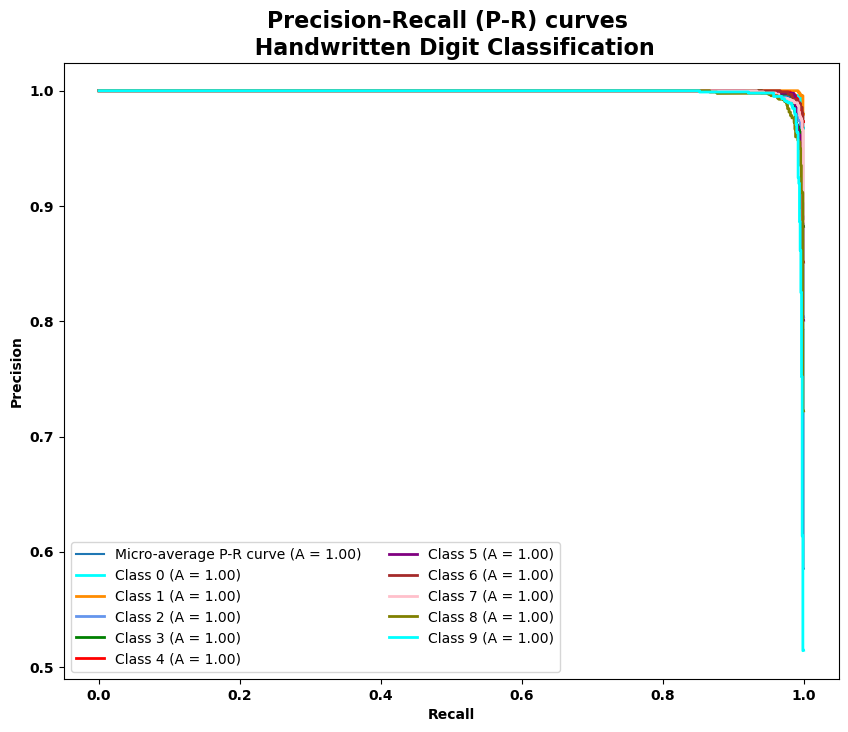

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       983
           1       1.00      1.00      1.00      1152
           2       0.98      0.99      0.99       967
           3       0.99      0.99      0.99      1034
           4       0.99      0.99      0.99       906
           5       0.99      0.99      0.99       937
           6       0.99      1.00      0.99       961
           7       0.99      0.99      0.99      1055
           8       0.98      0.98      0.98       969
           9       0.99      0.98      0.99      1036

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [26]:
# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

# Binarize the output labels (convert them to one-vs-rest format for multi-class precision-recall)
y_true = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_true.shape[1]

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], preds_test[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], preds_test[:, i])

# Compute micro-average Precision-Recall curve and average precision score
precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(), preds_test.ravel())
average_precision["micro"] = average_precision_score(y_true, preds_test, average="micro")

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'olive', 'cyan']
plt.plot(recall["micro"], precision["micro"], label='Micro-average P-R curve (A = {0:0.2f})'
                                                   ''.format(average_precision["micro"]))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], color=colors[i], lw=2,
             label='Class {0} (A = {1:0.2f})'.format(i, average_precision[i]))

plt.xlabel('Recall', fontweight = 'bold')
plt.ylabel('Precision', fontweight = 'bold')
plt.xticks(fontweight = 'bold')
plt.yticks(fontweight = 'bold')
plt.title('Precision-Recall (P-R) curves \n Handwritten Digit Classification', fontweight = 'bold', fontsize = 16)
plt.legend(loc="lower left", ncol = 2)
plt.show()

# Print classification report for additional insights
print(classification_report(y_test, y_pred))